In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import pandas as pd
import json
import flappy_bird_gymnasium

In [3]:
# Configuración para forzar el uso de GPU si está disponible
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Permitir el crecimiento de la memoria GPU para evitar que TensorFlow reserve toda la memoria de la GPU de inmediato
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Se han encontrado las siguientes GPUs:", gpus)
    except RuntimeError as e:
        print("Error al configurar el crecimiento de memoria en GPU:", e)
else:
    print("No se encontró GPU, se usará CPU.")

Se han encontrado las siguientes GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
env = gym.make("FlappyBird-v0", use_lidar=False)
num_actions = env.action_space.n

In [5]:
class DQN(tf.keras.Model):
    """Perceptron multicapa de 2 capas de 32 y una de salida."""
    def __init__(self):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation="relu")
        self.dense2 = tf.keras.layers.Dense(32, activation="relu")
        self.dense3 = tf.keras.layers.Dense(num_actions, dtype=tf.float32)
        # No se define activación en la capa de salida para obtener valores Q sin restricciones

    def call(self, x):
        """Construcción de las capas."""
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

# Forzar la creación de los modelos en la GPU (si está disponible)
with tf.device('/GPU:0'):
    main_nn = DQN()    # Red principal
    target_nn = DQN()  # Red objetivo

optimizer = tf.keras.optimizers.Adam(1e-4)  # Optimizador Adam
mse = tf.keras.losses.MeanSquaredError()      # Función de pérdida MSE

In [6]:
class ReplayBuffer(object):
    """Experience replay buffer that samples uniformly."""
    
    def __init__(self, size):
        self.buffer = deque(maxlen=size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def __len__(self):
        return len(self.buffer)
    
    def sample(self, num_samples):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idx = np.random.choice(len(self.buffer), num_samples)
        for i in idx:
            state, action, reward, next_state, done = self.buffer[i]
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones, dtype=np.float32)
        return states, actions, rewards, next_states, dones

In [7]:
def select_epsilon_greedy_action(state, epsilon):
    """Acción aleatoria con probabilidad epsilon; de lo contrario, la mejor acción (greedy)."""
    result = tf.random.uniform((1,))
    if result < epsilon:    
        return env.action_space.sample()  # Elegimos una acción aleatoria
    else:   
        return tf.argmax(main_nn(state)[0]).numpy()  # Elección de acción Greedy.

discount = 0.99
# Forzar la ejecución de la función de entrenamiento en GPU
with tf.device('/GPU:0'):
    @tf.function  # Compila la función para ejecución optimizada
    def train_step(states, actions, rewards, next_states, dones):
        # Cálculo de los objetivos usando la red objetivo
        next_qs = target_nn(next_states)
        max_next_qs = tf.reduce_max(next_qs, axis=-1)
        target = rewards + (1. - dones) * discount * max_next_qs

        with tf.GradientTape() as tape:
            qs = main_nn(states)
            action_masks = tf.one_hot(actions, num_actions)
            masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
            loss = mse(target, masked_qs)
        
        grads = tape.gradient(loss, main_nn.trainable_variables)
        optimizer.apply_gradients(zip(grads, main_nn.trainable_variables))
        
        return loss

In [7]:
# Crear la carpeta "results" si no existe
results_folder = 'results/flappybird'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Hyperparámetros
num_episodes = 10000
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000)
cur_frame = 0

# Variables para registrar resultados
last_100_ep_rewards = []   # Últimas 100 recompensas para calcular el promedio
episode_rewards = []       # Recompensa de cada episodio

# Variables para guardar los mejores resultados
global_best_reward = -np.inf  # Mejor recompensa en un episodio
best_avg_reward = -np.inf  # Mejor promedio en ventana de 100 episodios

for episode in range(num_episodes + 1):
    state, info = env.reset()  # Reseteo del entorno
    ep_reward, done = 0, False
    
    while not done:
        state_in = tf.expand_dims(state, axis=0)
        action = select_epsilon_greedy_action(state_in, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        ep_reward += reward
        
        # Guardamos la experiencia en el buffer
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1
        
        # Copiamos los pesos de main_nn a target_nn cada 2000 frames
        if cur_frame % 2000 == 0:
            target_nn.set_weights(main_nn.get_weights())
        
        # Entrenamiento de la red si hay suficientes muestras
        if len(buffer) >= batch_size:
            with tf.device('/GPU:0'):
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                loss = train_step(states, actions, rewards, next_states, dones)
    
    # Decremento de epsilon para favorecer la acción Greedy durante el entrenamiento
    if episode < 950:
        epsilon -= 0.001
    
    # Actualizamos el registro de las últimas 100 recompensas
    if len(last_100_ep_rewards) == 100:
        last_100_ep_rewards = last_100_ep_rewards[1:]
    last_100_ep_rewards.append(ep_reward)
    episode_rewards.append(ep_reward)
    
    # Guardamos el modelo si se obtiene un nuevo mejor reward global
    if ep_reward > global_best_reward:
        global_best_reward = ep_reward
        main_nn.save_weights(os.path.join(results_folder, 'best_model_global_weights.h5'))
    
    # Guardamos el modelo con el mejor promedio en los últimos 100 episodios
    if episode >= 100:
        current_avg = np.mean(last_100_ep_rewards)
        if current_avg > best_avg_reward:
            best_avg_reward = current_avg
            main_nn.save_weights(os.path.join(results_folder, 'best_model_avg100_weights.h5'))
    
    # Imprimimos la información cada 50 episodios
    if episode % 50 == 0:
        print(
            f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}. '
            f'Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.3f}. '
            f'Best reward so far: {global_best_reward:.3f}. '
        )

env.close()

# Guardamos la recompensa de cada episodio en un CSV dentro de la carpeta "results"
df = pd.DataFrame({
    'Episode': list(range(len(episode_rewards))),
    'Reward': episode_rewards
})
df.to_csv(os.path.join(results_folder, 'rewards_log.csv'), index=False)

# Convertir a tipos nativos de Python para evitar problemas con JSON
results_summary = {
    'global_best_reward': float(global_best_reward),
    'best_avg_reward': float(best_avg_reward)
}

with open(os.path.join(results_folder, 'results_summary.json'), 'w') as f:
    json.dump(results_summary, f, indent=4)

Episode 0/10000. Epsilon: 0.999. Reward in last 100 episodes: -5.700. Best reward so far: -5.700. 
Episode 50/10000. Epsilon: 0.949. Reward in last 100 episodes: -7.641. Best reward so far: -4.500. 
Episode 100/10000. Epsilon: 0.899. Reward in last 100 episodes: -7.590. Best reward so far: 2.700. 
Episode 150/10000. Epsilon: 0.849. Reward in last 100 episodes: -7.524. Best reward so far: 2.700. 
Episode 200/10000. Epsilon: 0.799. Reward in last 100 episodes: -7.386. Best reward so far: 2.700. 
Episode 250/10000. Epsilon: 0.749. Reward in last 100 episodes: -6.942. Best reward so far: 2.700. 
Episode 300/10000. Epsilon: 0.699. Reward in last 100 episodes: -6.516. Best reward so far: 3.300. 
Episode 350/10000. Epsilon: 0.649. Reward in last 100 episodes: -5.814. Best reward so far: 3.900. 
Episode 400/10000. Epsilon: 0.599. Reward in last 100 episodes: -4.890. Best reward so far: 3.900. 
Episode 450/10000. Epsilon: 0.549. Reward in last 100 episodes: -4.248. Best reward so far: 3.900. 
E

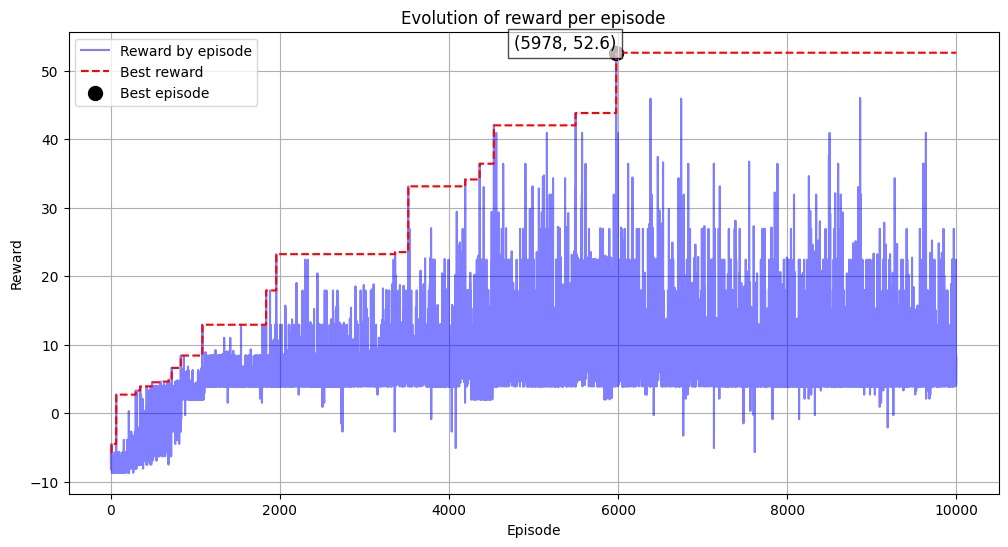

In [8]:
# Definir la carpeta donde se guardaron los resultados
results_folder = 'results/flappybird'

# Cargar el CSV con las recompensas de cada episodio
csv_path = os.path.join(results_folder, 'rewards_log.csv')
df = pd.read_csv(csv_path)

# Cargar el resumen de resultados desde el JSON
json_path = os.path.join(results_folder, 'results_summary.json')
with open(json_path, 'r') as f:
    results_summary = json.load(f)

# Obtener la mejor recompensa global y su episodio
global_best_reward = results_summary['global_best_reward']
best_episode_global = df['Reward'].idxmax()  # Encuentra el episodio con la mejor recompensa

# Calcular el "mejor reward acumulado" (cumulative max)
df['best_so_far'] = df['Reward'].cummax()

# Crear la figura
plt.figure(figsize=(12, 6))

# Gráfica de la recompensa por episodio (línea azul)
plt.plot(df['Episode'], df['Reward'], label='Reward by episode', color='blue', alpha=0.5)

# Gráfica de la evolución del mejor reward (línea roja punteada)
plt.plot(df['Episode'], df['best_so_far'], label='Best reward', color='red', linestyle='--')

# Agregar un punto en la mejor recompensa global
plt.scatter(best_episode_global, global_best_reward, color='black', marker='o', s=100, label='Best episode')

# Agregar texto con el episodio y la recompensa
plt.text(
    best_episode_global, global_best_reward,
    f'({best_episode_global}, {global_best_reward:.1f})',
    fontsize=12, verticalalignment='bottom', horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
)

# Configuración de la gráfica
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Evolution of reward per episode')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Crear el entorno de test con render_mode para capturar frames
env_test = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=False)

# Crear la carpeta para guardar los videos de test
video_folder = os.path.join('results/flappybird', 'test_videos')
os.makedirs(video_folder, exist_ok=True)

# Envolver el entorno con RecordVideo para grabar cada episodio
env_test = RecordVideo(env_test, video_folder=video_folder, 
                       episode_trigger=lambda ep: True, name_prefix="test_episode")

# Inicializar la red para test
test_nn = DQN()

# ⚠️ "Construir" el modelo con una entrada ficticia antes de cargar los pesos
dummy_input = tf.random.uniform(shape=(1, env_test.observation_space.shape[0]))  # Entrada ficticia
test_nn(dummy_input)  # Llama al modelo para crear sus variables internas

# Cargar los pesos del mejor modelo guardado
weights_path = os.path.join('results/flappybird', 'best_model_avg100_weights.h5')
if os.path.exists(weights_path):
    test_nn.load_weights(weights_path)
    print("Modelo cargado para test desde:", weights_path)
else:
    print("No se encontraron pesos guardados. Se usará el modelo actual.")

# Número de episodios de test
test_episodes = 10

# Ejecutar episodios de test
for ep in range(test_episodes):
    state, info = env_test.reset()  # Reinicia el entorno
    done = False
    ep_reward = 0
    while not done:
        # Política greedy: se toma la acción con mayor Q-value
        state_in = tf.expand_dims(state, axis=0)
        action = tf.argmax(test_nn(state_in)[0]).numpy()
        next_state, reward, terminated, truncated, info = env_test.step(action)
        done = terminated or truncated
        ep_reward += reward
        state = next_state
    print(f"Test Episode {ep+1}: Reward = {ep_reward:.2f}")

env_test.close()
print(f"Videos guardados en la carpeta: {video_folder}")

Modelo cargado para test desde: results/flappybird\best_model_avg100_weights.h5
Test Episode 1: Reward = 8.50
Test Episode 2: Reward = 8.40
Test Episode 3: Reward = 12.90
Test Episode 4: Reward = 8.40
Test Episode 5: Reward = 8.40
Test Episode 6: Reward = 22.60
Test Episode 7: Reward = 78.50
Test Episode 8: Reward = 36.90
Test Episode 9: Reward = 22.40
Test Episode 10: Reward = 8.40
Videos guardados en la carpeta: results/flappybird\test_videos
